In [79]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

output_SAM = pickle.load(open("/homedata/mcarenso/Stage2023/SAM/300K/AgeAnalysis.pkl", "rb"))
output_ICON = pickle.load(open("/homedata/mcarenso/Stage2023/ICON/300K_no_filter/AgeAnalysis.pkl", "rb"))
output_MESONH = pickle.load(open("/homedata/mcarenso/Stage2023/MESONH/300K/AgeAnalysis.pkl", "rb"))
outputs = [output_SAM, output_MESONH, output_ICON]
#Ages_over_bins, Ages_of_Xprecip, Xprecip_over_ages, Xprecip_counts, Ages_per_duration in each output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
SAM_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
Precip_SAM = xr.open_dataarray(SAM_path, engine= "netcdf4")

In [81]:
figures_SAM_path = "/homedata/mcarenso/Stage2023/SAM/300K/Figures/"
figures_ICON_path = "/homedata/mcarenso/Stage2023/ICON/300K_no_filter/Figures/"
figures_MESONH_path = "/homedata/mcarenso/Stage2023/MESONH/300K/Figures/"
figures_path = [figures_SAM_path, figures_MESONH_path, figures_ICON_path]   
figures_All_path = "/homedata/mcarenso/Stage2023/Figures/"
sim_names = ["SAM", "MNH", "ICON"]

In [82]:
distrib_SAM_path = "/homedata/mcarenso/Stage2023/SAM/300K/Distribution_Precip_5decades.pkl"
distrib_ICON_path = "/homedata/mcarenso/Stage2023/ICON/300K_no_filter/Distribution_Precip_5decades.pkl"
distrib_MESONH_path = "/homedata/mcarenso/Stage2023/MESONH/300K/Distribution_Precip_5decades.pkl"

distrib_MESONH = pickle.load(open(distrib_MESONH_path, "rb"))
distrib_ICON = pickle.load(open(distrib_ICON_path, "rb"))
distrib_SAM = pickle.load(open(distrib_SAM_path, "rb"))

distribs = [distrib_SAM, distrib_MESONH, distrib_ICON]

In [83]:
sim_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
Precip = xr.open_dataarray(sim_path, engine= "netcdf4")
Precip

<xarray.DataArray 'pr' (time: 1200, latitude: 128, longitude: 2048)>
[314572800 values with dtype=float32]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:      mm/h
    long_name:  pr

In [84]:
def get_data_from_output(dist, output):
    Q1, median, Q3 = [], [], []
    ages_over_bins = output[0]
    for bin_ages in ages_over_bins:
        if len(bin_ages) == 0:
            Q1.append(np.nan)
            median.append(np.nan)
            Q3.append(np.nan)
        else: 
            q1, med, q3 = np.quantile(bin_ages, [0.25, 0.5, 0.75])
            Q1.append(q1)
            median.append(med)
            Q3.append(q3)
    Q1 = np.array(Q1)
    median = np.array(median)
    Q3 = np.array(Q3)
    return Q1, median, Q3

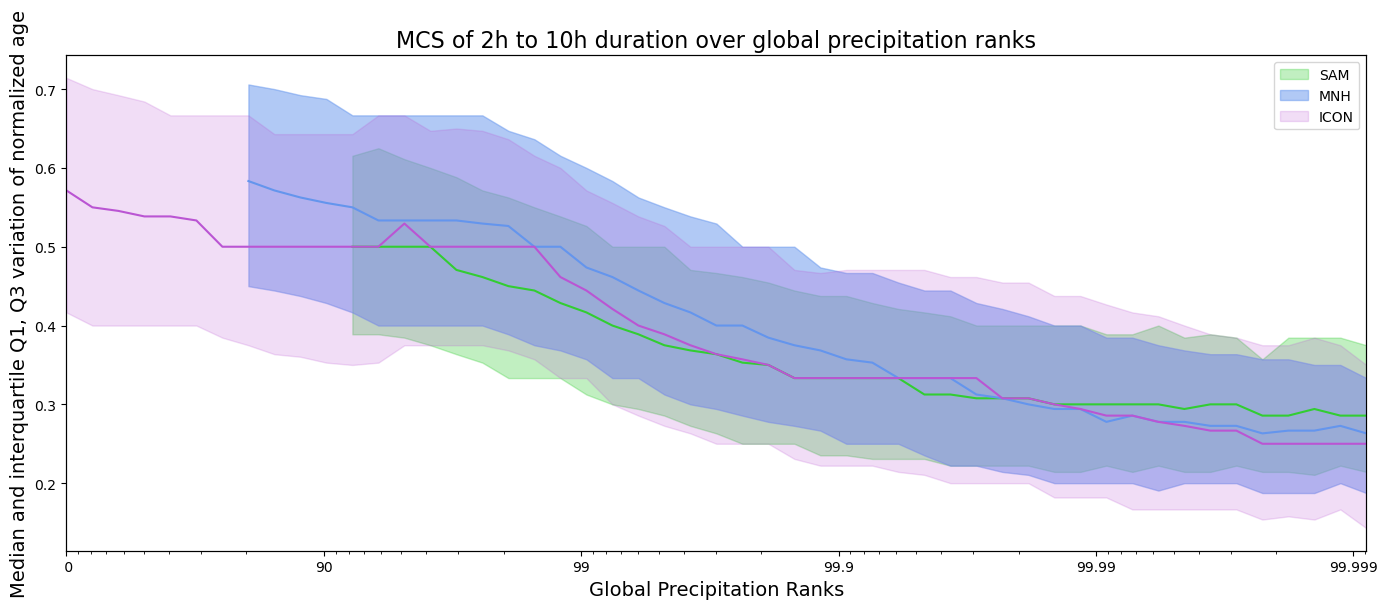

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

x = distribs[0].ranks
setXaxisIL(ax, x)
ax_show = ax.twiny()

colors = ['limegreen', 'cornflowerblue', 'mediumorchid']
alpha_values = [0.3, 0.5, 0.2]

for idx, dist, output, color, alpha in zip(range(0, len(distribs)), distribs, outputs, colors, alpha_values):
    Q1, median, Q3 = get_data_from_output(dist, output)
    
    fillBetweenQuartilesShowData(ax_show, x, median, Q1, Q3, rankmin=0, rankmax=99.999, color=color, alpha=alpha, label=sim_names[idx])
    
ax_show.set_xticks([]) 
ax.set_xlabel("Global Precipitation Ranks", fontsize=14)
ax.set_ylabel("Median and interquartile Q1, Q3 variation of normalized age", fontsize=14)
ax.set_title("MCS of 2h to 10h duration over global precipitation ranks", fontsize=16)

plt.tight_layout()
plt.savefig(figures_All_path + "Ages_over_bins.png", dpi=300)
plt.legend()
plt.show()


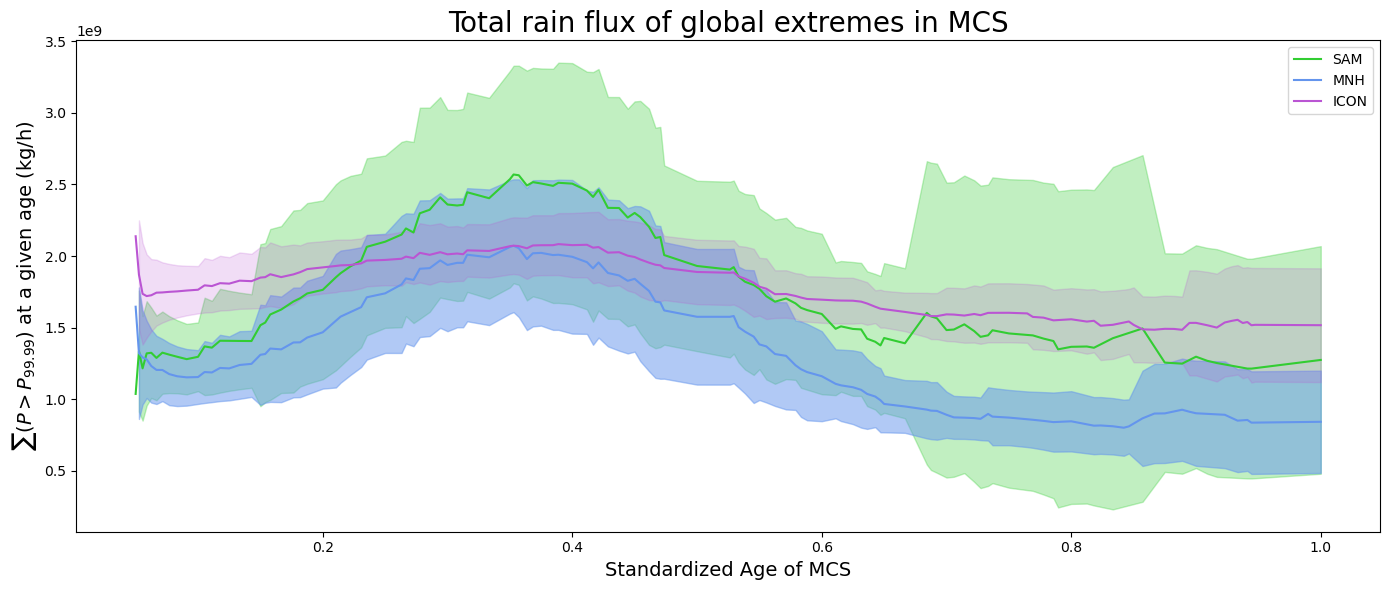

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i, output, color, alpha in zip(range(len(outputs)), outputs, colors, alpha_values):
    #retrieve data out of output
    Xprecip_over_ages = output[2]
    Ages_of_Xprecip = output[1]
    # Calculate moving average
    window_width = 20  # Change this value to adjust the width of the moving average
    rolling_average = pd.Series(Xprecip_over_ages).multiply(9*1e6).rolling(window=window_width, min_periods=1).mean()
    rolling_std = (pd.Series(Xprecip_over_ages).multiply(9*1e6).rolling(window=window_width, min_periods=1)).std()
    # Plot the moving average
    plt.plot(Ages_of_Xprecip, rolling_average, label = sim_names[i], color = color)
    plt.fill_between(Ages_of_Xprecip, rolling_average - rolling_std, rolling_average + rolling_std, color = color, alpha= alpha)
plt.xlabel('Standardized Age of MCS', fontsize=14)
plt.ylabel(r'$\sum(P > P_{99.99})$ at a given age (kg/h)', fontsize=14) ## TODO : multiply by surface square (and pho constant)
plt.title('Total rain flux of global extremes in MCS', fontsize=20)
plt.tight_layout()
plt.legend()
plt.savefig(figures_All_path + "Xprecip_over_ages_width20.png", dpi = 300)
plt.show()


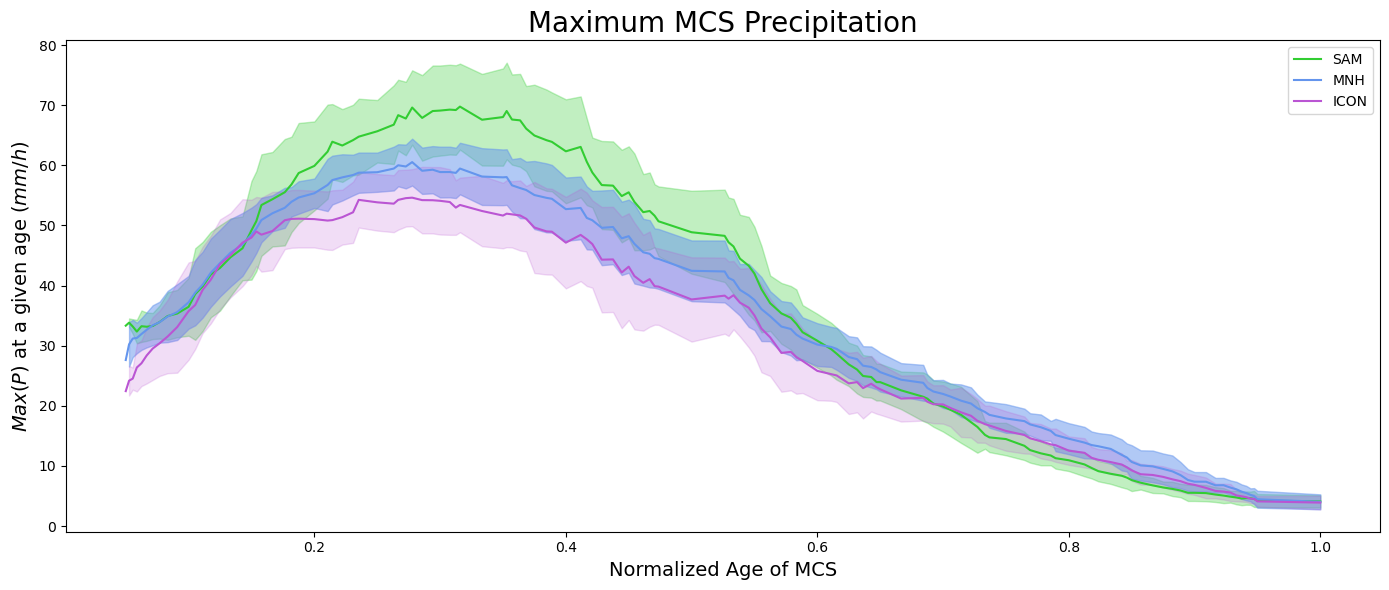

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i, output, color, alpha in zip(range(len(outputs)), outputs, colors, alpha_values):
    #retrieve data out of output
    Maxprecip_over_ages = output[6]
    Ages_of_Maxprecip = output[5]
    # Calculate moving average
    window_width = 10  # Change this value to adjust the width of the moving average
    rolling_average = pd.Series(Maxprecip_over_ages).rolling(window=window_width, min_periods=1).mean()
    rolling_std = pd.Series(Maxprecip_over_ages).rolling(window=window_width, min_periods=1).std()
    # Plot the moving average
    plt.plot(Ages_of_Maxprecip, rolling_average, label = sim_names[i], color = color)
    plt.fill_between(Ages_of_Maxprecip, rolling_average - rolling_std, rolling_average + rolling_std, alpha= alpha, color = color)
plt.xlabel('Normalized Age of MCS', fontsize=14)
plt.ylabel(r'$Max(P)$ at a given age $(mm/h)$', fontsize=14)
plt.title('Maximum MCS Precipitation', fontsize=20)
plt.tight_layout()
plt.savefig(figures_All_path + "Xprecip_over_ages_width20.png", dpi = 300)
plt.legend()
plt.show()


## Distrib plot with percentiles over ranks


In [88]:
sam_dist_path = "/homedata/mcarenso/Stage2023/SAM/300K/Distribution_Precip_5decades.pkl" 
mnh_dist_path = "/homedata/mcarenso/Stage2023/MESONH/300K/Distribution_Precip_5decades.pkl" 
ico_dist_path = "/homedata/mcarenso/Stage2023/ICON/300K_no_filter/Distribution_Precip_5decades.pkl" 

## pickle load each distribution
sam_dist = pickle.load(open(sam_dist_path, "rb"))
mnh_dist = pickle.load(open(mnh_dist_path, "rb"))
ico_dist = pickle.load(open(ico_dist_path, "rb"))

distribs = [sam_dist, mnh_dist, ico_dist]

In [89]:
## import the precip frac under MCS

sam_frac_rain = "/homedata/mcarenso/Stage2023/SAM/300K/perc_MCS_over_rain_300.pkl"
mnh_frac_rain = "/homedata/mcarenso/Stage2023/MESONH/300K/perc_MCS_over_rain_300.pkl"
icon_frac_rain= "/homedata/mcarenso/Stage2023/ICON/300K_no_filter/perc_MCS_over_rain_300.pkl"

frac_rain = [pickle.load(open(sam_frac_rain, "rb")), pickle.load(open(mnh_frac_rain, "rb")), pickle.load(open(icon_frac_rain, "rb"))]

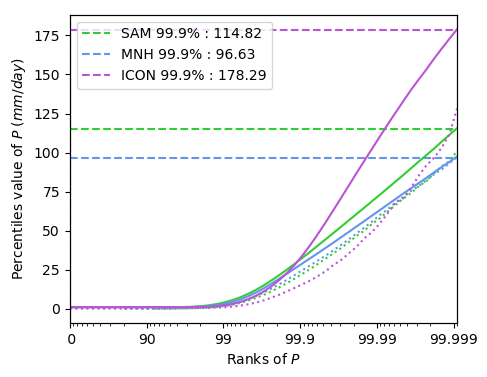

In [90]:
## Plot the distribution of precipitations
fig, ax = plt.subplots(figsize=(5, 4))
#--- on IL x axis
ax_show = ax.twiny()
slice_x_from = 0
setXaxisIL(ax, sam_dist.ranks[slice_x_from:])
horizontal_line = [dist.percentiles[-1] for dist in distribs]

for i, dist in enumerate(distribs):
    frac = frac_rain[i]
    # x y data
    ranks = dist.ranks[slice_x_from:]
    perc= dist.percentiles[slice_x_from:]
    perc = np.array(perc) +1.0

    # print('check that the curve bounds match')
    # print('y bounds:',perc[slice_x_from:][0],perc[slice_x_from:][-1])
    # print()

    showData(ax_show,ranks,perc, rankmax = 99.999, color = colors[i]) #, label = sim_names[i])
    showData(ax_show,ranks,perc*frac, rankmax = 99.999, linestyle = ':', color = colors[i])#, label = "% under MCS")
    
    ax.axhline(y=horizontal_line[i], color = colors[i], linestyle = '--', label = sim_names[i]+f" 99.9% : {np.round(horizontal_line[i], 2)}")
    ax.legend(loc = 'upper left')
    
ax.axvline(x=1/(1-(99.999)/100), color = 'black', linestyle = ':', label = "99.9 ranks value")
    
ax.set_xlabel('Ranks of $P$')
ax.set_ylabel('Percentiles value of $P$ $(mm/day)$')
plt.show()

In [12]:
horizontal_line = [dist.percentiles[-1] for dist in distribs]
horizontal_line

[114.81957076331128, 96.62873842455883, 178.28509530957672]

## MAX|MCS Precip analysis


In [13]:
# path to the files
sam_path = "/homedata/mcarenso/Stage2023/SAM/300K/MaxPrecipAnalysis/25days/Max_Precip_per_MCS_data_and_dist.pkl"
mnh_path = "/homedata/mcarenso/Stage2023/MESONH/300K/MaxPrecipAnalysis/25days/Max_Precip_per_MCS_data_and_dist.pkl"
icon_path = '/homedata/mcarenso/Stage2023/ICON/300K_no_filter/MaxPrecipAnalysis/25days/Max_Precip_per_MCS_data_and_dist.pkl'

In [14]:
# load sam
sam_data = pickle.load(open(sam_path, "rb"))
sam_ages_over_bins = pickle.load(open("/homedata/mcarenso/Stage2023/SAM/300K/MaxPrecipAnalysis/25days/Ages_of_MaxPrecip_over_bins.pkl", "rb"))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


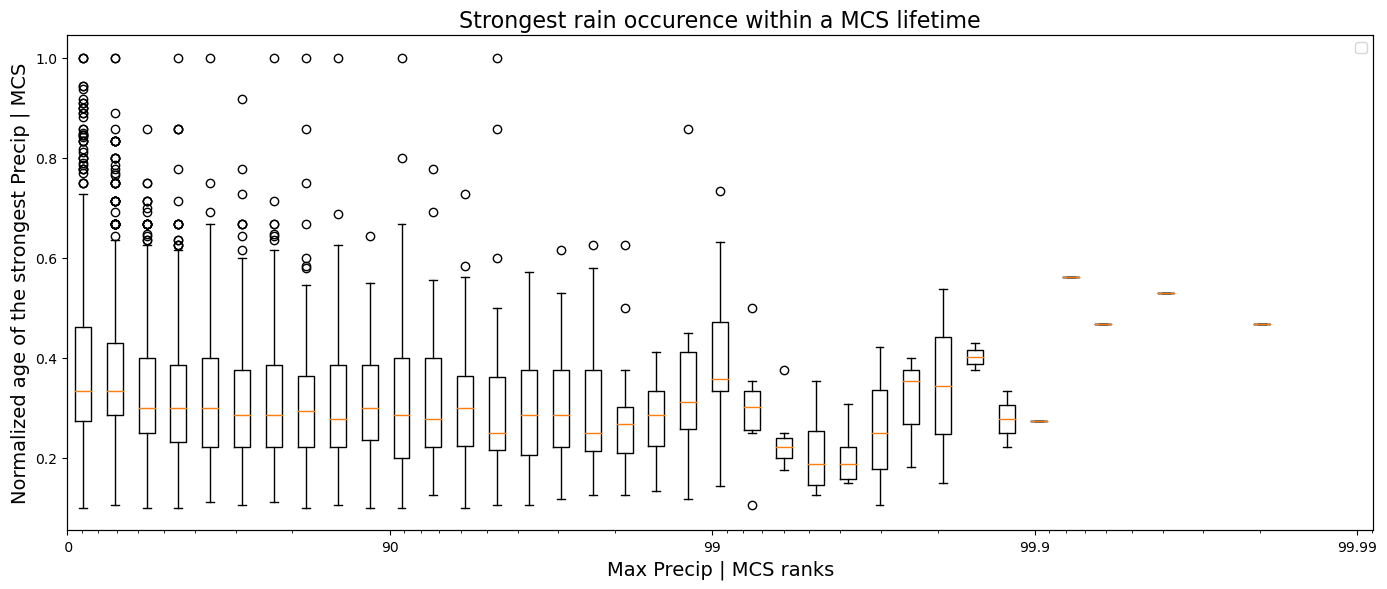

In [15]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=sam_data[0].ranks

setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(sam_ages_over_bins)
ax_show.set_xticks([])

ax.set_xlabel("Max Precip | MCS ranks", fontsize = 14)

ax.set_ylabel("Normalized age of the strongest Precip | MCS", fontsize = 14)
plt.legend()
plt.title("Strongest rain occurence within a MCS lifetime", fontsize = 16)
plt.tight_layout()
#plt.savefig("Ages_over_bins.png", dpi = 300)
plt.show()

# WIP

In [16]:
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'
sim_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
output_path = "/homedata/mcarenso/Stage2023/SAM/"+"300"+"K/"

## Load data
print("Loading data...")
Precip = xr.open_dataset(sim_path, engine= "netcdf4")

## Import MCS list and prepare label list
from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
MCS_labels = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file
def idx_by_label(labels, label_list = MCS_labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

MCS_2h_to_10h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in np.arange(4, 21, 1).astype(int).tolist()]
MCS_2h_to_10h_labels = [MCS_2h_to_10h[i].label for i in range(len(MCS_2h_to_10h))]
        
## label_mask contains the label of the MCS over the map
label_mask = xr.open_dataarray(file_seg, chunks = {'time' :48, 'longitude' : 32, 'latitude' : 32}).isel(time=slice(48*25)).astype(int) 
## adapt label_mask to 2h_10h MCS
label_2h_to_10h_mask = label_mask.where(label_mask.isin(MCS_2h_to_10h_labels))

mask_2h_to_10h = ~label_2h_to_10h_mask.where(label_2h_to_10h_mask.isnull(), False).isnull()

filename = "Max_Precip_per_MCS_data_and_dist"

Loading data...


In [10]:
path = "/homedata/mcarenso/Stage2023/SAM/300K/max"